# 0 - Introdução

# 1 - Importa libs

In [1]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pickle

pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', '{:.2f}'.format)

# 2 - Funções

Gráficos

In [2]:
# def plot_transacoes_step(df):

#     step_counts = df.groupby('step')['id'].count()

#     plt.figure(figsize=(12, 6))
#     step_counts.plot(kind='line', color='blue', marker='o', linestyle='-', alpha=0.8)

#     plt.title('Número de Transações por Step', fontsize=16)
#     plt.xlabel('Step (Horas)', fontsize=14)
#     plt.ylabel('Número de Transações', fontsize=14)
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.xticks(fontsize=12)
#     plt.yticks(fontsize=12)
#     plt.tight_layout()
    
#     plt.show()

In [3]:
def plot_transacoes_step(df):

    step_counts = df.groupby('step')['id'].count().reset_index()
    step_counts.columns = ['step', 'transaction_count']

    fig = px.line(
        step_counts, 
        x='step', 
        y='transaction_count', 
        title='Número de Transações por Step',
        labels={'step': 'Step (Horas)', 'transaction_count': 'Número de Transações'},
        markers=True
    )

    max_step = step_counts['step'].max()
    for step in range(24, max_step + 1, 24):
        fig.add_vline(
            x=step, 
            line_dash="dash", 
            line_color="red", 
            line_width=0.3,
            # annotation_text=f"Step {step}", 
            # annotation_position="top"
        )

    fig.update_layout(
        title_font_size=20,
        xaxis_title_font_size=16,
        yaxis_title_font_size=16,
        template='plotly_white',
        hovermode='x'
    )

    fig.show()

In [4]:
# def plot_fraud_analysis(df):

#     grouped = df.groupby(['step', 'isFraud'])['id'].count().reset_index()
#     grouped.columns = ['step', 'isFraud', 'transaction_count']

#     pivot = grouped.pivot(index='step', columns='isFraud', values='transaction_count').fillna(0)
#     pivot.columns = ['not_fraud', 'fraud']
#     pivot['total'] = pivot['not_fraud'] + pivot['fraud']
#     pivot['fraud_ratio'] = pivot['fraud'] / pivot['total']

#     fig = px.line(
#         pivot.reset_index(), 
#         x='step', 
#         y=['total', 'fraud', 'not_fraud'], 
#         labels={
#             'value': 'Número de Transações',
#             'variable': 'Tipo de Transação',
#             'step': 'Step (Horas)'
#         },
#         title='Comparação de Transações Gerais, Fraudes e Não Fraudes',
#         markers=True
#     )

#     fig.add_scatter(
#         x=pivot.index, 
#         y=pivot['fraud_ratio'] * 100, 
#         mode='lines+markers', 
#         name='Proporção de Fraudes (%)',
#         line=dict(dash='dash', color='red')
#     )

#     fig.update_layout(
#         template='plotly_white',
#         xaxis_title='Step (Horas)',
#         yaxis_title='Número de Transações',
#         title_font_size=20,
#         xaxis_title_font_size=16,
#         yaxis_title_font_size=16,
#         legend_title_font_size=14,
#         hovermode='x'
#     )

#     fig.show()

In [5]:
def plot_fraud_ratio(df):

    grouped = df.groupby(['step', 'isFraud'])['id'].count().reset_index()
    grouped.columns = ['step', 'isFraud', 'transaction_count']

    pivot = grouped.pivot(index='step', columns='isFraud', values='transaction_count').fillna(0)
    pivot.columns = ['not_fraud', 'fraud']
    pivot['total'] = pivot['not_fraud'] + pivot['fraud']
    pivot['fraud_ratio'] = pivot['fraud'] / pivot['total']

    fig = px.line(
        pivot.reset_index(), 
        x='step', 
        y='fraud_ratio', 
        labels={
            'step': 'Step (Horas)',
            'fraud_ratio': 'Proporção de Fraudes'
        },
        title='Proporção de Fraudes ao Longo do Tempo',
        markers=True
    )

    fig.update_layout(
        template='plotly_white',
        xaxis_title='Step (Horas)',
        yaxis_title='Proporção de Fraudes',
        title_font_size=20,
        xaxis_title_font_size=16,
        yaxis_title_font_size=16,
        legend_title_font_size=14,
        hovermode='x'
    )

    fig.show()

# 3 - Carrega base de dados

Aqui faço o download de alguns datasets disponíveis no Kaggle e escolho um para desenvolver o modelo.  

### Dataset escolhido - Synthetic Financial Datasets For Fraud Detection | PaySim  
[Kaggle | PaySim dataset](https://www.kaggle.com/datasets/ealaxi/paysim1)

#### Colunas do dataset:  

- step - mapeia uma unidade de tempo no mundo real. Neste caso, 1 step é 1 hora de tempo. Total de steps: 744 (simulação de 30 dias)  

- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT e TRANSFER  

- amount - valor da transação na moeda local  

- nameOrig - cliente que iniciou a transação  

- oldbalanceOrg - saldo inicial antes da transação  

- newbalanceOrig - novo saldo após a transação  

- nameDest - cliente que é o destinatário da transação  

- oldbalanceDest - saldo inicial do destinatário antes da transação. Note que não há informações para clientes cujo nome começa com M (Mercadores)  

- newbalanceDest - novo saldo do destinatário após a transação. Note que não há informações para clientes cujo nome começa com M (Mercadores).  

- isFraud - Transações realizadas pelos agentes fraudulentos dentro da simulação. Neste conjunto de dados específico, o comportamento fraudulento dos agentes visa lucrar ao assumir o controle das contas dos clientes e tentar esvaziar os fundos transferindo para outra conta e, em seguida, retirando o dinheiro do sistema.  

- isFlaggedFraud - O modelo de negócios visa controlar transferências massivas de uma conta para outra e sinalizar tentativas ilegais. Uma tentativa ilegal neste conjunto de dados é uma tentativa de transferir mais de 200.000 em uma única transação.

#### Download dataset:  

In [6]:
# subprocess.run(["kaggle", "datasets", "download", "ealaxi/paysim1", "-p", "../data/raw", "--unzip"])

# 4 - Conhecendo o dataset

EDA - Exploratory data analysis.

In [7]:
df = pd.read_csv('../data/raw/PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [9]:
df.shape

(6362620, 11)

In [10]:
df['id'] = df.index

#### Analisando a frequência das transações

In [11]:
# Todas

plot_transacoes_step(df)

In [12]:
# Somente as fraudes

plot_transacoes_step(df[df['isFraud']==1])

In [13]:
plot_fraud_ratio(df)

In [14]:
grouped = df.groupby(['step', 'isFraud'])['id'].count().reset_index()
grouped.columns = ['step', 'isFraud', 'transaction_count']

pivot = grouped.pivot(index='step', columns='isFraud', values='transaction_count').fillna(0)
pivot.columns = ['not_fraud', 'fraud']
pivot['total'] = pivot['not_fraud'] + pivot['fraud']
pivot['fraud_ratio'] = pivot['fraud'] / pivot['total']

In [15]:
pivot

,not_fraud,fraud,total,fraud_ratio
step,,,,
1,2692.00,16.00,2708.00,0.01
2,1006.00,8.00,1014.00,0.01
3,548.00,4.00,552.00,0.01
4,555.00,10.00,565.00,0.02
5,659.00,6.00,665.00,0.01
...,...,...,...,...
739,0.00,10.00,10.00,1.00
740,0.00,6.00,6.00,1.00
741,0.00,22.00,22.00,1.00


In [16]:
pivot[pivot['not_fraud']==0]

,not_fraud,fraud,total,fraud_ratio
step,,,,
28,0.00,4.00,4.00,1.00
29,0.00,4.00,4.00,1.00
30,0.00,8.00,8.00,1.00
31,0.00,12.00,12.00,1.00
32,0.00,12.00,12.00,1.00
...,...,...,...,...
739,0.00,10.00,10.00,1.00
740,0.00,6.00,6.00,1.00
741,0.00,22.00,22.00,1.00


Conclusão:  

Apesar de estarmos lidando com uma base de dados desbalanceada, temos 320 steps (horas) em que todas as transações são fraudes.  
Isso é uma dica valiosa para a detecção das fraudes e podemos criar novas features explorando esse comportamento.  

# 5 Baseline - modelo

In [17]:
f

NameError: name 'f' is not defined

Estamos lidando com um modelo de classificação, desbalanceado.  

In [ ]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [ ]:
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [47]:
df.head(1)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,id
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0


In [ ]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
id                0
dtype: int64

Split

In [59]:
X = df.drop(columns=['isFraud', 'isFlaggedFraud', 'id', 'nameOrig', 'nameDest'])
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Pré processamento

In [60]:
categorical_features = ['type']
numeric_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

In [ ]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = StandardScaler()

In [64]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [65]:
model = RandomForestClassifier(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

In [66]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['type'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [69]:
y_pred = pipeline.predict(X_test)

In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.96      0.79      0.87      1643

    accuracy                           1.00   1272524
   macro avg       0.98      0.89      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524



Salvando o modelo

In [68]:
model_path = '../models/pipeline_model_baseline.pkl'

with open(model_path, 'wb') as file:
    pickle.dump(pipeline, file)

# 6 Feature engineering

In [18]:
df['hour_of_day'] = df['step'] % 24
df['day_of_week'] = (df['step'] // 24) % 7

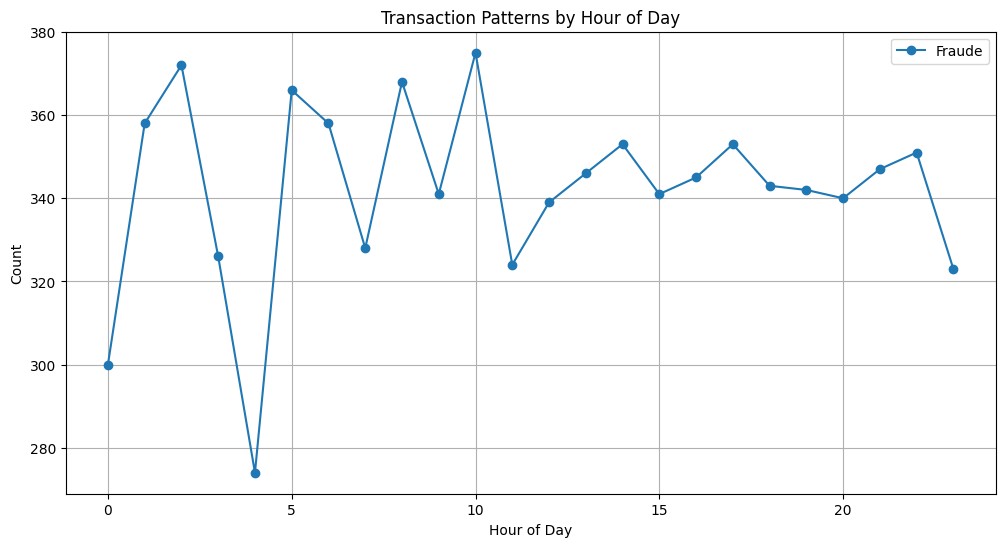

In [19]:
# Frequência de fraude por hora do dia
fraud_by_hour = df[df['isFraud'] == 1]['hour_of_day'].value_counts().sort_index()
normal_by_hour = df[df['isFraud'] == 0]['hour_of_day'].value_counts().sort_index()

# Plotar para comparar
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(fraud_by_hour.index, fraud_by_hour.values, label='Fraude', marker='o')
# plt.plot(normal_by_hour.index, normal_by_hour.values, label='Normal', marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.title('Transaction Patterns by Hour of Day')
plt.legend()
plt.grid(True)
plt.show()

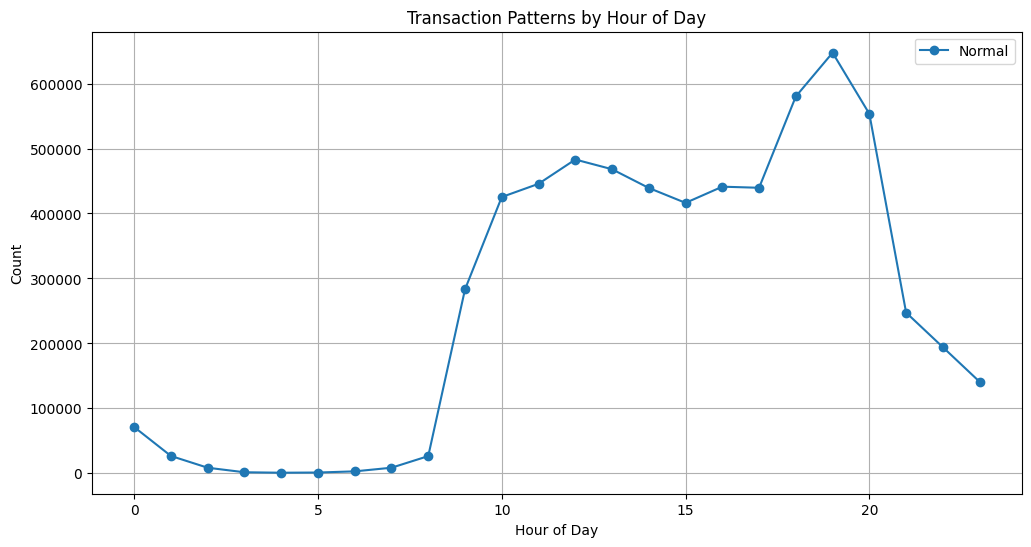

In [20]:
# Frequência de fraude por hora do dia
fraud_by_hour = df[df['isFraud'] == 1]['hour_of_day'].value_counts().sort_index()
normal_by_hour = df[df['isFraud'] == 0]['hour_of_day'].value_counts().sort_index()

# Plotar para comparar
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
# plt.plot(fraud_by_hour.index, fraud_by_hour.values, label='Fraude', marker='o')
plt.plot(normal_by_hour.index, normal_by_hour.values, label='Normal', marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.title('Transaction Patterns by Hour of Day')
plt.legend()
plt.grid(True)
plt.show()

# 7 Melhorando modelo com novas variáveis

In [21]:
df.head(1)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,id,hour_of_day,day_of_week
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,1,0


In [22]:
X = df.drop(columns=['step','isFraud', 'isFlaggedFraud', 'id', 'nameOrig', 'nameDest'])
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
categorical_features = ['type']
numeric_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest','hour_of_day','day_of_week']

In [24]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = StandardScaler()

In [25]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [26]:
model = RandomForestClassifier(random_state=42)

In [27]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

In [30]:
pipeline.fit(X_train, y_train)

KeyboardInterrupt: 

In [29]:
y_pred = pipeline.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.98      0.80      0.88      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.90      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524



# Feature importance

# Predict dos dois pkl em uma base externa

# Ganhos em R$

Sem nenhum modelo (isFlaggedFraud)  
Sem feature engineering  
Com feature engineering  